# Trefethen Code

## 1. Evaluate $\pi$ by arithmetic geometric mean

Borwein & Borwein (SIAM Review 1984)

In [1]:
function pi_agm(; n=6)
    y = √(√2)
    x = (y+1/y) / 2
    p = 2 + √2
    
    for i = 1:n
        println(p)
        
        p = p * (1+x)/(1+y)
        s = √x
        y = (y*s+1/s) / (1+y)
        x = (s+1/s) / 2
    end
end


pi_agm (generic function with 1 method)

In [2]:
pi_agm()

3.414213562373095
3.1426067539416227
3.141592660966044
3.141592653589793
3.141592653589793
3.141592653589793


## 2. Chebyshev

This function serves as the basis for any Chebyshev collocation spectral method.

compute D = differentiation matrix, x = Chebyshev grid

In [3]:
function cheb(N)
    if N == 0
        D = 0
        x = 1
        
        return D, x 
    end
    
    x = [cos(π*j/N) for j = 0:N]'
    c = [2; ones(N-1); 2].*[(-1)^j for j = 0:N]
    X = zeros(N+1, N+1)
    
    for i = 1:N+1
        X[:, i] = x
    end
    
    dX = X - X'
    D = (c*(1./c)')./(dX+(eye(N+1)))
    D = D - diagm(sum(D,2)[:])
    
    return D, x
end

cheb (generic function with 1 method)

In [4]:
D, x = cheb(10); size(D)

(11,11)

## 3. Chebyshev coefficients

Use FFT to compute chebyshev coeffs of
$$f(x)=e^x.$$

Here, a smooth function $f(x)$ on [-1,1] has a chebyshev expansion

$$f(x)=\Sigma_{k=0}^\infty a_k T_k(x)$$

and 

$$a_k=\frac{2}{\pi} \int_{-1}^1 (1-x^2)^{-1/2} f(x) T_k(x) dx,$$
    
where $T_k$ is the $k$th chebyshev polynomial (except for $k$=0 the factor is 1/π, not 2/π).

See e.g., Mason & Handscomb, Chebyshev Polynomials (2003).

In [5]:
function cheb_coeffs(f::Function; n=14)
    x = [cos(π*j/n) for j = 0:(2*n-1)] # chebyshev points(twice)
    g = real(fft(f(x)))/(2*n) # fft of f evaluated at pts
    a = [g[i] + g[2*n+2-i] for i = 2:n]
    a = [g[1]; a] # chebyshev coeffs
    # exact = [2*besseli(i,1) for i = 1:(n-1)]
    # exact = [besseli(0,1); exact] # analytic solution
end

cheb_coeffs (generic function with 1 method)

In [6]:
f = x->exp(x); cheb_coeffs(f)

14-element Array{Float64,1}:
 1.26607    
 1.13032    
 0.271495   
 0.0443368  
 0.00547424 
 0.000542926
 4.49773e-5 
 3.19844e-6 
 1.99212e-7 
 1.10368e-8 
 5.5059e-10 
 2.49796e-11
 1.03925e-12
 3.9968e-14 

## 4. Gauss quadrature nodes and weights on [-1,1]

This function computes nodes (column vector x) and weights (row vector w) for the N-point Gauss-Legendre quadrature formula:

$$\int_{-1}^1 f(s)ds \approx w*f(x)$$

where x and w are obtained from a tridiagonal eigenvalue problem as proposed by Golub & Welsch (Math. Comp. 1969), an idea previously considered by Goertzel 1954, Wilf 1960, and Gordon 1968; see Gautschi, Orthogonal Polynomials: Computation and Approximation, Oxford 2004.

This code comes from Trefethen, Spectral Methods in MATLAB, 2000. 

In [7]:
function gauss(N)
    β = [.5/sqrt(1-(2.0*j)^(-2)) for j = 1:N-1] # 3-term recurrence coeffs.
    d = [0 for j = 1:N]
    T = SymTridiagonal(d,β) # set up Jacobi matrix
    D, V = eig(T) # the eigenvalue problem
    # nodes
    w = [2*V[1,i]^2 for i = 1:N] # weights
    
    return D, w
end

gauss (generic function with 1 method)

In [8]:
gauss(10)

([-0.973907,-0.865063,-0.67941,-0.433395,-0.148874,0.148874,0.433395,0.67941,0.865063,0.973907],[0.0666713,0.149451,0.219086,0.269267,0.295524,0.295524,0.269267,0.219086,0.149451,0.0666713])

## 5. Compute pseudospectra of 60x60 Grcar matrix

This program computes pseudospectra by a method much faster than the obvious one of simply computing the SVD at many points. The algorithm is due to Lui (SIAM J. Sci. Comp. 1997) and Trefethen(Acta Numerica 1999). 

The same algorithm is used by EigTool (Wright 2002).

In [16]:
function rsf2csf(T, U)
#RSF2CSF Real block diagonal form to complex diagonal form.
#   [U,T] = RSF2CSF(U,T) transforms the outputs of SCHUR(X) (where X
#   is real) from Real Schur Form to Complex Schur Form.  The Real
#   Schur Form has the real eigenvalues on the diagonal and the
#   complex eigenvalues in 2-by-2 blocks on the diagonal.  The Complex
#   Schur Form is upper triangular with the eigenvalues of X on the
#   diagonal.
#   
#   Arguments U and T represent the unitary and Schur forms of a 
#   matrix A, such that A = U*T*U' and U'*U = eye(size(A)).
#
#   Class support for inputs U,T:
#      float: double, single
#
#   See also SCHUR.

#   Copyright 1984-2007 The MathWorks, Inc. 

    #!!have some problems
# Find complex unitary similarities to zero subdiagonal elements.
    
    n = size(T, 2);
    
    for m = n:-1:2
       # We are honouring the deflation from SCHUR. It may not work correctly if
       # the input is not an output of SCHUR.
       if T[m,m-1] != 0
          k = m-1:m;
          mu = eig(T[k,k]) - T[m,m];
          r = hypot(mu(1), T(m,m-1)); # hypot(a, b) = sqrt(abs(a).^2 + abs(b).^2)
          # hypot(w+im*x, u+im*y) = sqrt(abs(w).^2+abs(x).^2+abs(u).^2+abs(y).^2)
          c = mu[1]/r; s = T[m, m-1]/r;
          G = [c' s; -s c];
          T[k, m-1:n] = G * T[k, m-1:n];
          T[1:m, k] = T[1:m, k] * G';
          U[:, k] = U[:, k] * G';
          T[m, m-1] = 0;
       end
    end
    
    return T, U
end

using Plots
#Step 1: Define matrix and set up grid for contour plot
N = 60
# A = gallery('grcar', N) # Grcar matrix
A = zeros(N, N)

for i = 1:N
    A[i,i] = 1
    
    if i < N
        A[i+1, i] = -1
        A[i, i+1] = 1
    end
    
    if i < N-1
        A[i, i+2] = 1
    end
    
    if i < N-2
        A[i, i+3] = 1
    end
end

npts = 40 # grid resolution
x1 = -2.4; x2 = 4.4; y1 = -3.4; y2 = 3.4 # grid limits
x = x1:(x2-x1)/(npts-1):x2
y = y1:(y2-y1)/(npts-1):y2

size_x = length(x)
size_y = length(y)

#[xx, yy] = meshgrid(x, y)
#xx = zeros(size_y, size_x)
#yy = zeros(size_y, size_x)
#for i = 1:size_y
#    xx[i, :] = x
#    yy[i, :] = y[i] * ones(size_x)
#end

xx = repmat(convert(Array,x)', size_y)
yy = repmat(convert(Array,y)', size_x)'
zz = xx + im * yy # gird

#Step 2: Compute Schur form and plot eigenvalues
T, U, λ = schur(A) # triangularize

if isreal(A)
    [U, T] = rsf2csf(U, T) # how to solve?
end

T = triu(T)

# eigA = diag(T) # eigenvalues

scatter(real(λ), imag(λ), w=10)
xlims!(x1, x2)
ylims!(y1, y2)
# axis square

#Step 3: Compute resolvent norms and plot contours
sigmin = Inf * ones(Complex, size_y, size_x)
for i = 1:size_y
    if (y2 == -y1) && (i > size_y/2) # exploit symmetry
        sigmin[i, :] = sigmin[size_y+1-i, :]
    else
        for j = 1:size_x
            z = zz[i, j]; T1 = z*I-T; T2 = T1' # shifted matrix
            sig = 0; sigold = 0; qold = zeros(N)
            β = 0; H = zeros(100, 100)
            q = randn(N) + im*randn(N); q = q/norm(q) # initial vector
            
            for k = 1:99 # crude Lanczos loop
                v = T1\(T2\q) - β*qold # inverse Lanczos step
                α = real(q'*v)[1]
                v = v - α*q
                β = norm(v); qold = q; q = v/β
                H[k+1, k] = β; H[k, k+1] = β # tridiagonal matrix
                H[k, k] = α
                sig = eigvals(H[1:k, 1:k])[1]
                if (abs(sigold/sig-1) < .001) #|| (sig < 3.0 && k > 2)
                    break
                end
                sigold = sig
            end
            sigmin[i, j] = 1/sqrt(complex(sig)) # min. singular value
        end
    end 
end
contour!(convert(Array,x), convert(Array,y), log10(sigmin+1e-20))
#contour(convert(Array,x), convert(Array,y), log10(sigmin+1e-20), -8:-1) # levels 1e-1 ... 1e-8
colormap("Grays") # make it monochrome

LoadError: MethodError: no method matching isless(::Float64, ::Complex{Float64})[0m
Closest candidates are:
  isless(::Float64, [1m[31m::Float64[0m) at float.jl:283
  isless(::AbstractFloat, [1m[31m::AbstractFloat[0m) at operators.jl:40
  isless(::Real, [1m[31m::AbstractFloat[0m) at operators.jl:41
  ...[0m

## 6. Solve KdV equation by Fourier spectral/ETDRK4 scheme

by A.-K. Kassam and L. N. Trefethen 4/03

This code solves the Korteweg-de Vries eq.

$$u_t+uu_x+u_{xxx}=0$$

with periodic BCs on [-$\pi$,$\pi$] and initial condition given by a pair of solitons. The curve evolves up to t=0.005 and at the end u(x=0) is printed to 6-digit accuracy. Changing N to 384 and h to 2.5e-7 improves this to 10 digits but takes four times longer.


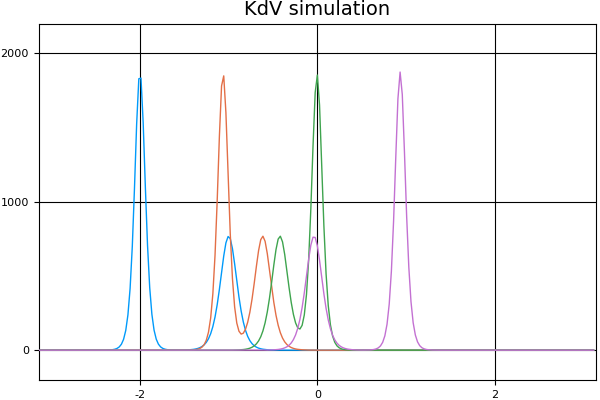

2017-03-14 22:07:13.298 julia[81787:14658936] kCFURLVolumeIsAutomountedKey missing for file:///private/var/folders/zz/zyxvpxvq6csfxvn_n0000000000000/T/FPInstallMountPoint/: The file “FPInstallMountPoint” couldn’t be opened because you don’t have permission to view it.


In [16]:
using Plots
# Step 1: Set up grid and two-soliton initial data:
N = 256; x = (2*π/N) * convert(Array, -N/2:N/2-1)
A = 25; B = 16
u = zeros(length(x), 101)
u[:, 1] = 3*A^2*sech(.5*(A*(x+2))).^2+3*B^2*sech(.5*(B*(x+1))).^2

# Step 2: Precompute ETDRK4 scalar quantities (Kassam-Trefethen):
h = 1e-6
k = vcat(0:N/2-1, 0, -N/2+1:-1)
L = im*k.^3
E = exp(h*L); E2 = exp(h*L/2)
M = 64
r = exp(2*im*π*(convert(Array, 1:M)-0.5)/M)
Ls = zeros(Complex, length(L), M)

for i = 1:M
    Ls[:, i] = L[:]
end

rs = zeros(Complex, N, length(r))

for j = 1:N
    rs[j, :] = r[:]
end

LR = h*Ls+rs
Q  = h*mean(                  (exp(LR/2)-1)./LR   ,2)[:]
f1 = h*mean((-4-LR+exp(LR).*(4-3*LR+LR.^2))./LR.^3,2)[:]
f2 = h*mean(    (4+2*LR+exp(LR).*(-4+2*LR))./LR.^3,2)[:]
f3 = h*mean((-4-3*LR-LR.^2+exp(LR).*(4-LR))./LR.^3,2)[:]
g = -.5*im*k

# Step 3: Time-stepping by ETDRK4 formula (Cox-Matthews):
t = 0; s = 0; Count = 1; v = fft(u[:, 1])
while t+h/2 < .005
    s = s+1
    t = t+h
    Nv = g.*fft(real(ifft(v)).^2)
    a = E2.*v+Q.*Nv;        Na = g.*fft(real(ifft(a)).^2)
    b = E2.*v+Q.*Na;        Nb = g.*fft(real(ifft(b)).^2)
    c = E2.*a+Q.*(2*Nb-Nv); Nc = g.*fft(real(ifft(c)).^2)
    v = E.*v+(Nv.*f1+(Na+Nb).*f2+Nc.*f3)
    
    if mod(s,50) == 0
        Count += 1
        u[:, Count] = real(ifft(v))[:]
    end
end

# Step 4: display this KdV solitons interaction simulation
# grid on
plot(x, [u[:,i] for i = 1:30:101], w=1, legend=false)
xlims!(-π, π)
ylims!(-200, 2200)
title!("KdV simulation")
#@gif for i=1:101
#    plot(x,u[:,i],w=1,legend=false)
#end every 30
#text([-2.4,900],u[Int(N/2+1),Count])
#wait(Timer(1e-4))
#title!(hcat(string("t = "),t))

## 7. Logistic function

Chaotic phenomena

$$x_{n+1}=r*x_n*(1-x_n).$$


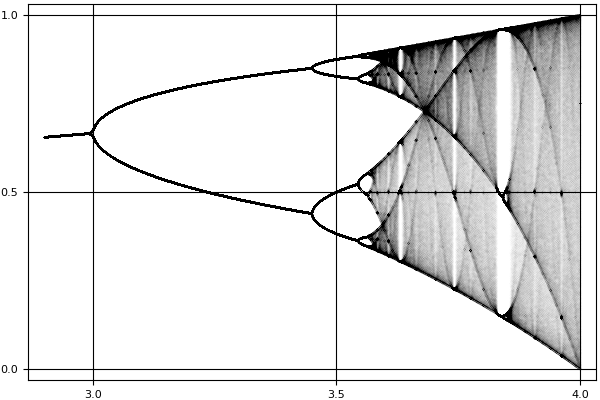

sys:1: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [1]:
r = 2.9:.00005:4; numAttract = 150
steady = ones(length(r), 1)*.25

for i = 1:400 # Get to steady state
  steady .= r.*steady.*(1-steady)
end

x = zeros(length(steady), numAttract)
x[:, 1] = steady

@inbounds for i = 2:numAttract # Grab values at the attractor
  x[:, i] = r.*x[:,i-1].*(1-x[:,i-1])
end

using Plots
plot(collect(r), x, seriestype=:scatter, markersize=.002, legend=false)